## Imports

In [1]:
%run base.ipynb
%load_ext autoreload
%autoreload 2

import pickle

import gym
import matplotlib.pyplot as plt

from abides_gym_custom_execution_environment_v0 import (
    SubGymMarketsCustomExecutionEnv_v0
)
from sigqlearning_qfunctions import SigQFunction
from sigqlearning_train_execution import train
from sigqlearning_test_execution import test
import utils

## Register the environment as gym environment

In [6]:
# register execution env for gym use 
from gym.envs.registration import register

register(
    id="custom-execution-v0",
    entry_point=SubGymMarketsCustomExecutionEnv_v0,
)

In [4]:
# helper function to generate environment with certain parameters
def generate_env(seed=None):
    """
    generates specific environment with the parameters defined and set the seed
    """
    env = gym.make(
            "custom-execution-v0",
            background_config="rmsc04",
            mkt_close="10:06:00",
            timestep_duration="10s",
            first_interval="00:05:00",
            observation_interval="00:01:00",            
            order_fixed_size=100,
            max_inventory=1000,
            starting_inventory=400,
            terminal_inventory_reward=-1, # reward or penalty
            running_inventory_reward_dampener=0., # 0.6, 1.0
            damp_mode="asymmetric", # asymmetric
            debug_mode=False
        )
    if seed is not None:
        env.seed(seed)
    return env

In [ ]:
# generate the custom execution environment
env = generate_env()

## Training

### Learn a Q-function estimate
Learn a Q-function estimate with Signature-Q-learning. We run 5 different seeds.

**Note**: 
- This code cell takes a long time to run. Would recommend to copy this cell in a python script and let it run in the back with [screen](https://linuxize.com/post/how-to-use-linux-screen/) or [tmux](https://www.hamvocke.com/blog/a-quick-and-easy-guide-to-tmux/) for instance. 

In [ ]:
from tqdm.notebook import tqdm

# signature config
sigq_params = dict(
    in_channels = 2, # time is added manually, no actions
    out_dimension = 3,
    sig_depth = 5,
    initial_basepoint = [-0.65, 1.], 
    initial_bias = 0.1
)

# training hyperparameters
n_runs = 2
n_episodes = 2000
truncation_order = 7

decay_mode = "episodes"
n_epochs = n_episodes if decay_mode == "episodes" else (
    n_episodes * 181 if decay_mode == "steps" else None
)

lr = 1e-4 # 5*1e-5
lr_decay = utils.linear_decay(epochs=n_epochs, start=lr, end=1e-7)
#lr_decay = utils.exponential_decay(factor=0.998)

eps = 0.8
eps_decay = utils.mixed_linear_decay(
    epochs=n_episodes, switch=n_episodes//2,
    schedule_1=utils.linear_decay(epochs=n_epochs//2, start=eps,  end=0.02),
    schedule_2=utils.linear_decay(epochs=n_epochs//2, start=0.02, end=0)
)

# dict to store results
training_results = {run : [] for run in range(n_runs)}
training_seeds = {
    run : seed for run,seed 
    in zip(training_results, utils.generate_prime_seeds(n_runs))
}

final_Q_functions = {}

# training runs
runs_pbar = tqdm(training_results.keys())
for run in runs_pbar:
    runs_pbar.set_description(f"Run")
    
    env = generate_env(training_seeds[run])
    #env.seed(training_seeds[run])
    
    sigpolicy = SigPolicy(env, truncation_order)
    sigpolicy.initialize_parameters(zero_bias=True)
    
    results = train(
        env, 
        sigpolicy, 
        n_episodes,
        discount=1.0, #1.
        learning_rate=lr, 
        learning_rate_decay=lr_decay,
        exploration="greedy",
        epsilon=eps,
        epsilon_decay=eps_decay,
        decay_mode=decay_mode,
        debug_mode=None,
        progress_display="progressbar"       
    )
    
    training_results[run] = results
    final_Q_functions[run] =  sigpolicy.state_dict()
    del sigpolicy # intermediate Q-estimates are saved in results

### Save training results

**Note**: Training results are saved under `file_name` concatenated with current date and time up to seconds.

In [ ]:
#file_name = "training_run_verification_new_env_1_lambda=1.0_lr_to_1e-7"
file_name = "custom_execution_v0_training_no_dampening_104"
utils.save_results(training_results, file_name)

In [ ]:
# custom_execution_v0_full_dampening
# 5 runs, i_0 = 400, oder_size=100, execution action space, with convergence to optimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 3,2,5,7,1, quadratic penalty C=-1, basepoint=T, discount=1., damp=1.

# custom_execution_v0_training_no_dampening
# 2 runs, i_0 = 400, oder_size=100, execution action space, with convergence to suboptimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 1000 epis , epis 1000, seeds (1,2) , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs not fully optimal, first only reduced down to 200, second overshoots then buys again and ends around -100

# custom_execution_v0_training_no_dampening_2
# 1 run, i_0 = 400, oder_size=100, execution action space, with convergence to optimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.

# custom_execution_v0_training_no_dampening_3
# 1 run, i_0 = 400, oder_size=100, execution action space, with convergence to SUBoptimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.

# custom_execution_v0_training_no_dampening_4
# 5 runs, i_0 = 400, oder_size=100, execution action space, some runs with convergence to suboptimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1,2,3,5,7 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# unstable training, mainly learns to leave inventory untouched

# custom_execution_v0_training_no_dampening_5
# 5 runs, i_0 = 400, oder_size=100, execution action space, some runs with only one convergence to optimal policy, trunc at 7, expl 500 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 1000 epis , epis 1000, seeds 1,2,3,5,7 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# only run 2 learned an acceptable policy, number of episodes to little, reduction from high exploration to low to fast

# INVALID – RUN AGAIN
# custom_execution_v0_training_no_dampening_6
# 2 runs, i_0 = 400, oder_size=100, execution action space, some runs with convergence to suboptimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 2000 epis , epis 2000, seeds 5,7 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs a bit suboptimal, first reduces too much end in [-200, 0], second also a little too much but good

# INVALID - RUN AGAIN 
# custom_execution_v0_training_no_dampening_7
# 2 runs, i_0 = 400, oder_size=100, execution action space, some runs with ?? convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-6 in 2000 epis , epis 2000, seeds 5,7 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# run 0 it learned a suboptimal policy, run a nearly optimal

# custom_execution_v0_training_no_dampening_8
# 2 runs, i_0 = 400, oder_size=100, execution action space, one run with convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr exp decay from 1e-3 with 0.995 , epis 2000, seeds 7,5 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0. 
# first runs optimal, second run shit

# custom_execution_v0_training_no_dampening_9
# 5 runs, i_0 = 400, oder_size=100, execution action space, no run with convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr exp decay from 1e-3 with 0.995 , epis 2000, seeds 1,2,3,5,7 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0. 
# shitty shit shit, why?

# custom_execution_v0_training_no_dampening_10
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr exp decay from 1e-4 with 0.997 , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0. 
# first run did not learn anything, second suboptimal reduces only to 200 high variance, lr decay too fast

# custom_execution_v0_training_no_dampening_11
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr episode exp decay from 1e-4 with 0.998 , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0. 
# first run did not learn much reduces only 300, second suboptimal reduces reduces a bit too much to -100

# ------ -------
# custom_execution_v0_training_no_dampening_12
# eps_start = 0.8 eps_end = 0.02, discount = 1.0
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence to almost optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs convergence to almost optimal policy, 2nd a bit better, both overshoot a little at beginning then buy again
# for intermediate -3, testing was even slightly better
# first Q values converge to mean reward with reward window [-200:0]

# custom_execution_v0_training_no_dampening_13
# eps_start = 0.8 eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# even a better than _12, it does not overshoot reduction of inventory, range of terminal inventory is smaller
# first run sometimes sells at end of episode, second run very stable 
# for intermediate -3 testing run_1 was better, run_2 sells to much at episode end, before would be really good
# first Q converges to value a bit below mean reward for both runs

# custom_execution_v0_training_no_dampening_14
# eps_start = 0.8 eps_end = 0.01, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.01, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# second run is really good, first run only reduces down to ~200 unfortunately 

# custom_execution_v0_training_no_dampening_15
# eps_start = 0.8 eps_end = 0.01, discount = 1.0
# 2 runs, i_0 = 400, oder_size=100, execution action space, convergence optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.01, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1.0, damp=0.
# First run learned nothing, reduces way too much than overshoots buying. Second run ok but in range [0, -200]

# ------ with eps start 0.5 ------
# custom_execution_v0_training_no_dampening_16
# eps_start = 0.5, eps_end = 0.02, discount = 1.0
# 2 runs, i_0 = 400, oder_size=100, execution action space, with no convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# no run did learn a good Q estimate
# first Q values did not converge properly

# custom_execution_v0_training_no_dampening_17
# eps_start = 0.5, eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, no convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# first run failed to converge, highly unstable in training, second run learned suboptimal policy, that reduces to 300 and only at end to 200
# first Q values did not converge

# ------ with decay mode 'steps' ------
# custom_execution_v0_training_no_dampening_18
# eps_start = 0.5, eps_end = 0.02, discount = 1.0, linear step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run suboptimal, reduced inventory but to a range [-100,100] and overshoot in buying and selling at beginning
# 2nd run did not learn anything useful

# custom_execution_v0_training_no_dampening_19
# eps_start = 0.8, eps_end = 0.02, discount = 1.0, linear step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run did not learn good policy, reduced halfway through the episode not stable
# 2nd run better, overshoots a little, intermediate at -31 is perfect

# custom_execution_v0_training_no_dampening_20
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, linear step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run suboptimal, wide range of terminal inventory on [-100,100]
# 2nd run learned good policy, but not particularly better than other cases with episode decay
# BUT perfect convergence of 1st Q value to mean reward !

# custom_execution_v0_training_no_dampening_20a
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, linear step decay, order size = 50
# 2 runs, i_0 = 400, oder_size=50, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# ADD DESCRIPTION

# TO RUN

# custom_execution_v0_training_no_dampening_21
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, linear step decay, lr start 5*1e-5
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 5*1e-5 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.

# custom_execution_v0_training_no_dampening_22
# eps_start = 1.0, eps_end = 0.02, discount = 1.0, exp step decay
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr exp step decay from 1e-4 with 0.999985 , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.

# custom_execution_v0_training_no_dampening_23
# eps_start = 0.5, eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.5, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.
# NO NEED FOR THIS ONE

# custom_execution_v0_training_no_dampening_24
# eps_start = 0.8, eps_end = 0.02, discount = 0.99
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=.99, damp=0.

# -------------
# custom_execution_v0_training_no_dampening_100
# eps_start = 0.8, eps_end = 0.02, discount = 1.0, linear step decay, order size = 50, current_inv as reward
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl 1000*181 steps, eps_start 1.0, eps_end 0.02, lr 1e-4 to 1e-7 in 2000*181 steps , epis 2000, seeds 1,2 , quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# ADD DESCRIPTION

# custom_execution_v0_training_no_dampening_101
# eps_start = 0.8 eps_end = 0.02, discount = 1.0, linear episode decay, current_inv as reward
# 1 run, i_0 = 400, oder_size=100, execution action space, with ?? convergence to almost optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1, quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# ADD DESCRIPTION

# custom_execution_v0_training_no_dampening_102
# eps_start = 0.8 eps_end = 0.02, discount = 1.0, linear episode decay, previous_inv as reward with linear terminal reward
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.02, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1, quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# 1st run learned nothing, 2nd run close to optimal, narrow range, similar to runs with same setup but quadratic terminal reward
# 3rd run with seed = 3 is running # ADD DECRIPTION

# custom_execution_v0_training_no_dampening_103
# eps_start = 0.8 eps_end = 0.02, discount = 1.0, linear episode decay, current as reward with flat terminal reward and 0 exploration
# 2 runs, i_0 = 400, oder_size=100, execution action space, with some convergence to optimal policy, trunc at 7, expl 1000 epis, eps_start 0.8, eps_end 0.0, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 1, quadratic penalty C=-1, basepoint=T, discount=1., damp=0.
# both runs learned a solid policy, however both only reduced to the range [50, 100] and not furhter
# -> not saved

# ************************************************************************************************************************************************************************************************************************************************************************************************************
# custom_execution_v0_training_no_dampening_104
# eps_start = 0.8, eps_mid=0.02, eps_end = 0.0, discount = 1.0, linear episode decay, previous as reward with flat terminal reward
# 2 runs, i_0 = 400, oder_size=100, execution action space, with ?? convergence to optimal policy, trunc at 7, expl mixed linear 2000 epis, eps_start 0.8, eps_mid=0.02 eps_end 0.0, lr 1e-4 to 1e-7 in 2000 epis , epis 2000, seeds 2,3, flat terminal penalty C=-1, basepoint=T, discount=1., damp=0.


# TO TRY:
# start with i_0=1400, i_max=2000



## Plot training results

### Plot single training run results

In [ ]:
# select training run number for plotting
run_id = 0
results = training_results[run_id]

utils.plot_results([
    results["rewards"],
    results["losses"],
    results["cash"],
    results["terminal_inventory"],
], size=(6,4))


### Plot single episode observation / action history.

In [ ]:
run_id = 1
episode_id = -601
env = generate_env()

observation_history = list(training_results[run_id]["observations"][episode_id])
action_history = training_results[run_id]["actions"][episode_id]

fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].plot(observation_history)
ax[0].set_xlabel(f"Observation history in episode {episode_id}")
ax[0].legend(["Time pct", "Inventory pct"], loc="best")

ax[1].plot(action_history)
ax[1].set_xlabel(f"Action history in episode {episode_id}")
actions = [*range(env.action_space.n)]
ax[1].set_yticks(actions, labels=[f"A{i}" for i in actions])
fig.tight_layout()
plt.show()

### Plot training statistics

In [ ]:
import numpy as np

keys_of_interest = ["rewards", "losses", "terminal_inventory"]
mean_dict = {}
std_dict = {}

# compute mean and standard deviation for keys of interest
for key in keys_of_interest:
    values = [run[key] for run in training_results.values()]
    mean_dict[key] = np.mean(values, axis=0)
    std_dict[key] = np.std(values, axis=0)

# names for plot titles
plot_names = ["reward", "loss", "terminal inventory"]
plot_names_dict = {key: name for key, name in zip(keys_of_interest, plot_names)}

# gernate mean + std plots
for key in keys_of_interest:
    plt.plot(mean_dict[key], color="b", label="mean " + plot_names_dict[key])
    plt.fill_between(
        range(len(mean_dict[key])),
        mean_dict[key] - 1 * std_dict[key],
        mean_dict[key] + 1 * std_dict[key],
        color="b", alpha=0.2, label="+/- standard deviation"
    )
    plt.xlabel("Episode")
    plt.title("Average {} per episode".format(plot_names_dict[key]))
    plt.legend(loc="best")
    plt.show()

## Testing

To load prior saved training results, set `load_training_results_flag` to True and paste trainings results' file name.

In [16]:
import pickle
load_training_results_flag = True

if load_training_results_flag:
    # load training results
    with open('../results/custom_execution_v0_training_no_dampening_13_24-01-2024_21:53:29.pkl', 'rb') as f:        
        training_results = pickle.load(f)
        print("*** training results loaded ***")

*** training results loaded ***


### Test a learned Q-function estimate

We test the Q-functions learning in training. If an intermediate Q-function estimate saved at some checkpoint instead of the last one for each training run should be tested, set `checkpoint_policy_flag` to True and select a checkpoint.

In [17]:
import random
import torch
from tqdm.notebook import tqdm

checkpoint_policy_flag = True
checkpoint = -1

truncation_order = 7
n_runs = len(training_results)
n_test_episodes = 5
test_results = {run : [] for run in range(n_runs)}

seeds = utils.generate_prime_seeds(100)

runs_pbar = tqdm(test_results.keys())
for run in runs_pbar:
    runs_pbar.set_description(f"Run")

    env = generate_env(random.choice(seeds))
    sigpolicy = SigPolicy(env, truncation_order)
    
    if checkpoint_policy_flag:
        sigpolicy.load_state_dict(training_results[run]["intermediate"][checkpoint])
    else:
        sigpolicy.load_state_dict(final_Q_functions[run])
    
    sigpolicy.eval()
    with torch.no_grad():
        test_results[run] = test(env, sigpolicy, n_test_episodes, epsilon=0., debug_mode="info")
    del(sigpolicy)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Episode 0 | Reward 0.01690 | Inventory 45 | Steps in run 181
Episode 1 | Reward -0.07314 | Inventory -1 | Steps in run 362
Episode 2 | Reward -0.03410 | Inventory -8 | Steps in run 543
Episode 3 | Reward -0.14662 | Inventory -145 | Steps in run 724
Episode 4 | Reward -0.02690 | Inventory -46 | Steps in run 905


  0%|          | 0/5 [00:00<?, ?it/s]

Episode 0 | Reward 0.00208 | Inventory 12 | Steps in run 181
Episode 1 | Reward 0.00136 | Inventory 6 | Steps in run 362
Episode 2 | Reward 0.00900 | Inventory 0 | Steps in run 543
Episode 3 | Reward 0.00200 | Inventory 0 | Steps in run 724
Episode 4 | Reward 0.01863 | Inventory 29 | Steps in run 905


## Plot test results

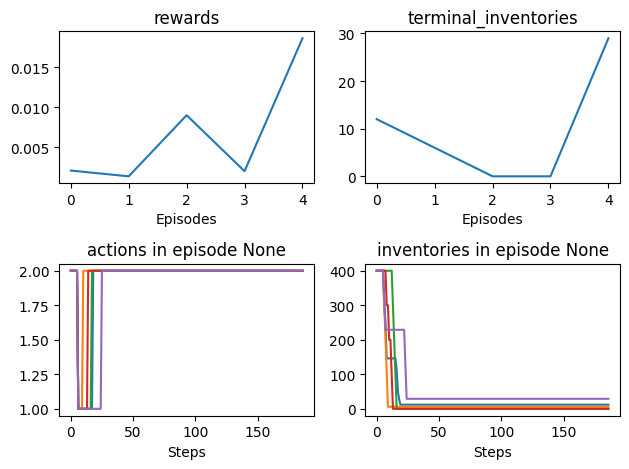

In [18]:
run_id = 1
episode_id = None
test_run = test_results[run_id]

rolling_avg_flag = False
rolling_avg_window = 0

names = ["rewards", "terminal_inventories", "actions", "inventories"]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False)
for ax, id in zip(axes.flat, range(4)):
    ax.set_title(names[id] if id < 2 else names[id] + (
                     " in episode " + str(episode_id) if episode_id != -1 else " in last episode")
    )
    if episode_id is not None:
        ax.plot(test_run[names[id]] if id < 2 else test_run[names[id]][episode_id])
    else:
        ax.plot(test_run[names[id]]) if id < 2 else [ax.plot(x) for x in test_run[names[id]]]

    if rolling_avg_flag:
        ax.plot(utils.moving_average(
                test_run[names[id]] if id < 2 else test_run[names[id]][episode_id], rolling_avg_window
            ))
    ax.set_xlabel("Episodes" if id < 2 else "Steps")
fig.tight_layout()
plt.show()

In [14]:
import numpy as np
print("""       |   reward: mean, std   |   inventory: mean, std   |    cash: mean, std """)
for i in range(len(test_results)):
    print(
        """run: {0} |    {1:0.4f}, {2:0.4f}    |    {3:0.4f}, {4:0.4f}    |    """.format(
            i, 
            np.mean(test_results[i]["rewards"]), np.std(test_results[i]["rewards"]),
            np.mean(test_results[i]["terminal_inventories"]), np.std(test_results[i]["terminal_inventories"])),
            np.mean(test_results[i]["cash"])/100, np.std(test_results[i]["cash"])/np.sqrt(100)
        )
    

       |   reward: mean, std   |   inventory: mean, std   |    cash: mean, std 
run: 0 |    -0.0210, 0.0406    |    -19.0000, 51.5286    |     419979.72799999994 514382.484569354
run: 1 |    -0.0661, 0.0459    |    9.4000, 94.7599    |     391623.422 947676.981915723


#### Save test results

In [ ]:
# WRITE test results
with open('../results/test_results_NEW.pkl', 'wb') as f:  
    pickle.dump(results, f)
f.close()

## Check first Q-value convergence

**Note**: We need to compare this with the average episode reward once all runs are performed. Also longer runs might be needed since I expect the average episode reward to be above the Q values reached with 250 episodes 

### With intermediate Q functions

observe first interval: True
basepoint: True


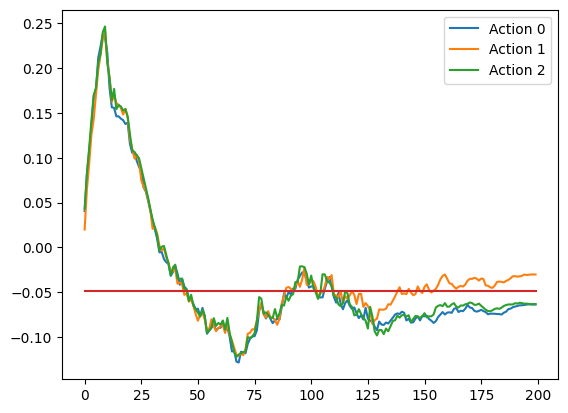

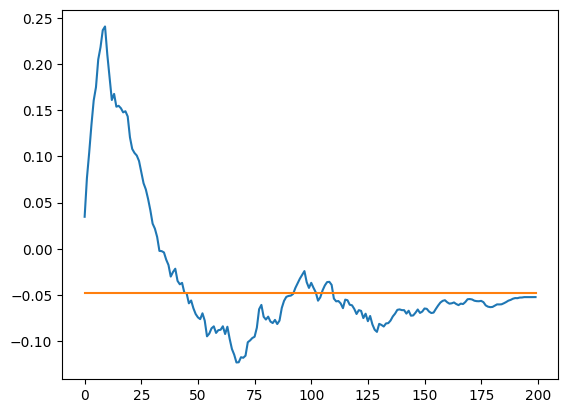

In [15]:
import torch
import math

run_id = 1
mean_epis = 100

observation_interval_flag = True if env.observation_interval > 0 else False
print("observe first interval: {}".format(observation_interval_flag))

basepoint_flag = True
print("basepoint: {}".format(basepoint_flag))

first_Q_values = []
policy = SigPolicy(env, truncation_order)

if observation_interval_flag:
    # steps to only observe
    do_nothing_steps = max(1, math.floor(env.observation_interval / env.timestep_duration))
    first_history = list(training_results[run_id]["observations"][0])[0:do_nothing_steps+1]
else:
    # no observation before first action
    first_history = list(training_results[run_id]["observations"][0])[0:2]
first_history = torch.tensor(
    first_history, requires_grad=False, dtype=torch.float
).unsqueeze(0)

for state_dict in training_results[run_id]["intermediate"]: 
    policy.load_state_dict(state_dict)    
    policy.eval()
    sig = policy.compute_signature(first_history, basepoint=basepoint_flag)  
    first_Q_values.append(policy(sig)[0].detach())
    policy.train()     

first_Q_values = torch.stack(first_Q_values, dim=0)
plt.plot(first_Q_values)
mean_reward = torch.tensor(training_results[run_id]["rewards"][-mean_epis:]).mean()
plt.plot([mean_reward for x in range(len(first_Q_values))])
plt.legend(["Action " + str(i) for i in range(first_Q_values.shape[-1])],
           loc="best")
plt.show()

first_Q_mean = first_Q_values.mean(dim=-1)
plt.plot(first_Q_mean)
mean_reward = torch.tensor(training_results[run_id]["rewards"][-mean_epis:]).mean()
plt.plot([mean_reward for x in range(len(first_Q_mean))])
plt.show()


### With saved Q-values

This section currently only works for training run `results_v2_copy_1214_2` and `results_v2_copy_1215_1`.

In [ ]:
Q_values = list(map(torch.detach, results["first_Q_values"]))
Q_values = [
    torch.stack(Q_values[i:i+181])
    for i in range(0, len(Q_values)-1, 181)
]

In [ ]:
episode_id = -1
plt.plot(Q_values[episode_id])
plt.legend(["Action " + str(i) for i in range(Q_values[episode_id].shape[-1])],
           loc="upper left")
plt.title("Q values in episode {}".format(episode_id))
plt.show()

first_Q_values = torch.stack([x[0] for x in Q_values], dim=0)
mean_reward = torch.tensor(results["rewards"][-300:]).mean()

plt.plot(first_Q_values)
plt.plot([mean_reward for x in range(len(first_Q_values))])
plt.legend([
        "Action " + str(i) 
        if i < first_Q_values.shape[-1] else "Mean reward" 
        for i in range(first_Q_values.shape[-1]+1)
    ],
    loc="upper right")
plt.title("First Q values per episode")
plt.show()
